In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

## Importanción de datos

In [73]:
! pip install papermill -q
! papermill --version

2.3.4 from /opt/conda/lib/python3.7/site-packages/papermill/cli.py (3.7.3)


In [77]:
months = ["2022-1","2022-2"]
archivo_final = "datos-completos.csv"

In [78]:
for month in months:
    ! papermill 'importar-mes.ipynb' 'import-result/{month}.ipynb' -p mes_datos {month} -p archivo_final {archivo_final}



Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-1.ipynb
Black is not installed, parameters wont be formatted
Executing: 100%|██████████████████████████████| 16/16 [03:00<00:00, 11.30s/cell]
Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-2.ipynb
Black is not installed, parameters wont be formatted
Executing: 100%|██████████████████████████████| 16/16 [03:21<00:00, 12.59s/cell]


In [86]:
df_original_corregido = spark.read.format("csv").options(header=True, delimiter=';',encoding="ISO-8859-1").csv('datos-completos.csv')

In [87]:
df_original_corregido.show(10,vertical=True)

-RECORD 0------------------------------------------
 ID                         | 41200292             
 Codigo                     | 653-4-SE20           
 Link                       | http://www.mercad... 
 Nombre                     | FTO DON CARLOS, C... 
 Descripcion/Obervaciones   | SERVICIOS DE F.T.... 
 Tipo                       | SE                   
 ProcedenciaOC              | Proveniente de li... 
 EsTratoDirecto             | No                   
 EsCompraAgil               | No                   
 CodigoTipo                 | 8                    
 CodigoAbreviadoTipoOC      | SE                   
 DescripcionTipoOC          | Sin emisión autom... 
 codigoEstado               | 6                    
 Estado                     | Aceptada             
 codigoEstadoProveedor      | 4                    
 EstadoProveedor            | Aceptada             
 FechaCreacion              | 2020-01-08           
 FechaEnvio                 | 2022-01-04           
 FechaSolici

## Ingeniería de Atributos

### Columnas Relevantes
Eliminamos las columnas que no sean relevanes para nuestro analisis, dejando solo las que sí podemos llegar a utilizar 

In [88]:
df_original = df_original_corregido

In [89]:
df_original.columns

['ID',
 'Codigo',
 'Link',
 'Nombre',
 'Descripcion/Obervaciones',
 'Tipo',
 'ProcedenciaOC',
 'EsTratoDirecto',
 'EsCompraAgil',
 'CodigoTipo',
 'CodigoAbreviadoTipoOC',
 'DescripcionTipoOC',
 'codigoEstado',
 'Estado',
 'codigoEstadoProveedor',
 'EstadoProveedor',
 'FechaCreacion',
 'FechaEnvio',
 'FechaSolicitudCancelacion',
 'fechaUltimaModificacion',
 'FechaAceptacion',
 'FechaCancelacion',
 'tieneItems',
 'PromedioCalificacion',
 'CantidadEvaluacion',
 'MontoTotalOC',
 'TipoMonedaOC',
 'MontoTotalOC_PesosChilenos',
 'Impuestos',
 'TipoImpuesto',
 'Descuentos',
 'Cargos',
 'TotalNetoOC',
 'CodigoUnidadCompra',
 'RutUnidadCompra',
 'UnidadCompra',
 'CodigoOrganismoPublico',
 'OrganismoPublico',
 'sector',
 'ActividadComprador',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisUnidadCompra',
 'CodigoSucursal',
 'RutSucursal',
 'Sucursal',
 'CodigoProveedor',
 'NombreProveedor',
 'ActividadProveedor',
 'ComunaProveedor',
 'RegionProveedor',
 'PaisProveedor',
 'Financiamiento',
 'P

In [90]:
df_columnas_relevantes = df_original[
    ['Estado',
 'FechaCreacion',
 'FechaAceptacion',
 'MontoTotalOC_PesosChilenos',
 'OrganismoPublico',
 'sector',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisProveedor',
 'IDItem',
 'RubroN1',
 'RubroN2',
 'RubroN3',
 'cantidad',
 'UnidadMedida']
]

In [91]:
df_columnas_relevantes.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2020-01-08           
 FechaAceptacion            | 2022-01-05           
 MontoTotalOC_PesosChilenos | 55699353,7632        
 OrganismoPublico           | SERVICIO DE VIVIE... 
 sector                     | Obras Públicas       
 CiudadUnidadCompra         | Talca                
 RegionUnidadCompra         | Región del Maule     
 PaisProveedor              | null                 
 IDItem                     | 108832323            
 RubroN1                    | Servicios profesi... 
 RubroN2                    | Consultorías o as... 
 RubroN3                    | Gestión de proyectos 
 cantidad                   | 1                    
 UnidadMedida               | Global               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2020-01-20           
 FechaAcepta

In [92]:
df_columnas_relevantes.count()

587933

#### Eliminar filas que no cuentas con un Estado válido. Deberían ser solo 5 posibles valores

In [93]:
df_columnas_relevantes.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Compra Ágil          
-RECORD 1----------------------
 Estado | Sin emisión autom... 
-RECORD 2----------------------
 Estado | Convenio Marco       
-RECORD 3----------------------
 Estado | 8                    
-RECORD 4----------------------
 Estado | Estado               
-RECORD 5----------------------
 Estado |  Llave               
-RECORD 6----------------------
 Estado | 6                    
-RECORD 7----------------------
 Estado | CM                   
-RECORD 8----------------------
 Estado | Cancelacion solic... 
-RECORD 9----------------------
 Estado | En proceso           
-RECORD 10---------------------
 Estado | Recepcion Conforme   
-RECORD 11---------------------
 Estado | Enviada a proveedor  
-RECORD 12---------------------
 Estado | 4                    
-RECORD 13---------------------
 Estado | 12                   
-RECORD 14---------------------
 Estado | Aceptada             



In [94]:
estados_validos = ["Aceptada", "En proceso","Cancelacion solicitada", "Enviada a proveedor", "Recepcion Conforme"] 

In [95]:
df_estados_validos =df_columnas_relevantes.filter(df_columnas_relevantes.Estado.isin(estados_validos))
df_estados_validos.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Cancelacion solic... 
-RECORD 1----------------------
 Estado | En proceso           
-RECORD 2----------------------
 Estado | Recepcion Conforme   
-RECORD 3----------------------
 Estado | Enviada a proveedor  
-RECORD 4----------------------
 Estado | Aceptada             



### Analisis de atributos


In [96]:
df = df_estados_validos

In [97]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: string (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: string (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: string (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [98]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0---------------------------
 Estado                     | 0     
 FechaCreacion              | 0     
 FechaAceptacion            | 0     
 MontoTotalOC_PesosChilenos | 0     
 OrganismoPublico           | 0     
 sector                     | 0     
 CiudadUnidadCompra         | 42    
 RegionUnidadCompra         | 0     
 PaisProveedor              | 44860 
 IDItem                     | 0     
 RubroN1                    | 0     
 RubroN2                    | 0     
 RubroN3                    | 0     
 cantidad                   | 4     
 UnidadMedida               | 3     



In [99]:
df.where(df.PaisProveedor.isNull()).count()

44860

In [100]:
df.count()

587720

##### De las 281895 originales, se eliminaron aproximadamente 245 líneas

Convertimos las fechas a formato fecha

In [101]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType, StringType

In [102]:
# # UDF to process the date column
# toDate = udf(lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())

In [103]:
# df = df \
#     .withColumn('FechaCreacion', toDate(col('FechaCreacion'))) \
#     .withColumn('FechaAceptacion', toDate(col('FechaAceptacion'))) 

In [104]:
df['FechaCreacion','FechaAceptacion'].printSchema()

root
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)



Convertimos los valores númericos a sus repectivos tipos

In [105]:
df = df \
    .withColumn('MontoTotalOC_PesosChilenos', col('MontoTotalOC_PesosChilenos').cast(DoubleType())) \
    .withColumn('IDItem', col('IDItem').cast(IntegerType())) \
    .withColumn('cantidad', col('cantidad').cast(DoubleType())) 

In [106]:
df['MontoTotalOC_PesosChilenos','IDItem', 'cantidad'].printSchema()

root
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- cantidad: double (nullable = true)



In [107]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: double (nullable = true)
 |-- UnidadMedida: string (nullable = true)



### Convertimos a Pandas

In [108]:
import sys
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [109]:
dfp = df.toPandas() 

In [110]:
dfp.head(10) 

,Estado,FechaCreacion,FechaAceptacion,MontoTotalOC_PesosChilenos,OrganismoPublico,sector,CiudadUnidadCompra,RegionUnidadCompra,PaisProveedor,IDItem,RubroN1,RubroN2,RubroN3,cantidad,UnidadMedida
0,Aceptada,2020-01-08,2022-01-05,NaN,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,None,108832323,"Servicios profesionales, administrativos y con...",Consultorías o asesorías en gestión empresarial,Gestión de proyectos,1.0,Global
1,Aceptada,2020-01-20,2022-05-02,NaN,I MUNICIPALIDAD DE PENCAHUE,Municipalidades,Pencahue,Región del Maule,Chile,109034639,Servicios de limpieza industrial,Eliminación y tratamiento de desechos,Eliminación de residuos no peligrosos,4800.0,Unidad
2,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112151073,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
3,Aceptada,2020-08-05,2022-01-10,11040465.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112151076,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
4,Aceptada,2020-08-05,2022-01-10,5953451.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153879,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
5,Aceptada,2020-08-05,2022-01-10,2650850.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153884,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
6,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153887,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
7,Aceptada,2020-08-05,2022-01-10,2852290.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153889,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
8,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153914,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
9,Aceptada,2020-08-05,2022-01-10,7645468.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153965,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad


In [111]:
df_category = dfp
print(df_category.columns)

Index(['Estado', 'FechaCreacion', 'FechaAceptacion',
       'MontoTotalOC_PesosChilenos', 'OrganismoPublico', 'sector',
       'CiudadUnidadCompra', 'RegionUnidadCompra', 'PaisProveedor', 'IDItem',
       'RubroN1', 'RubroN2', 'RubroN3', 'cantidad', 'UnidadMedida'],
      dtype='object')


In [112]:
for col in df_category.columns:
    df_category[col] = df_category[col].astype('category')
    df_category[col] = df_category[col].cat.codes

In [113]:
dfpandas = df_category

<AxesSubplot:>

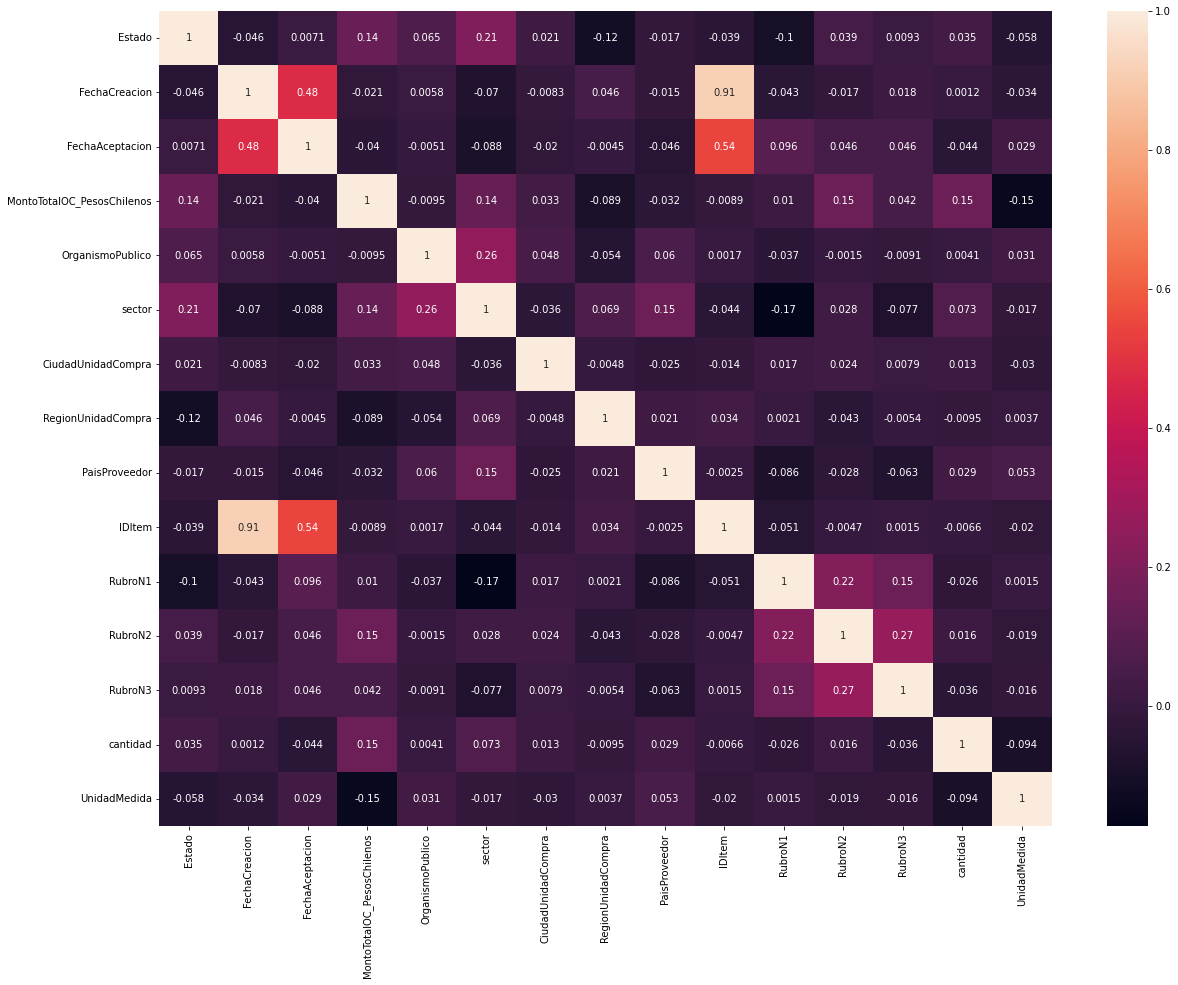

In [114]:
corr = dfpandas.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr,  annot = True)

In [115]:
# ! pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

In [116]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline

profile = ProfileReport(dfpandas, title="Compras del estado Chileno", minimal = True)

In [117]:
profile.to_file("ComprasChile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Análisis de DataSets en base a preguntas objetivo

In [118]:
from pyspark.sql.functions import *

In [119]:
df = df_estados_validos

In [120]:
df = df \
    .withColumn('MontoTotalOC_PesosChilenos', col('MontoTotalOC_PesosChilenos').cast(DoubleType())) \
    .withColumn('IDItem', col('IDItem').cast(IntegerType())) \
    .withColumn('cantidad', col('cantidad').cast(DoubleType())) 

In [121]:
# ¿Cuál fue el gasto promedio en general?
df.select(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).show()

+------------------+
|Promedio de Gastos|
+------------------+
| 5442746.214279486|
+------------------+



In [122]:
# ¿Cuántos gastos mayores al millón de dólares fueron efectuados entre el año 2021 y mayo de 2022?
df.select(max(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Maximo de Gastos")).show()


+--------------------+
|    Maximo de Gastos|
+--------------------+
|3.109149624676410...|
+--------------------+



In [123]:
# ¿Qué áreas está el Estado chileno invirtiendo más?
df.groupBy("OrganismoPublico").agg(sum(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Total Gastos")).orderBy(desc("Total Gastos")).show(truncate=False)

+---------------------------------------------------------------------+---------------------+
|OrganismoPublico                                                     |Total Gastos         |
+---------------------------------------------------------------------+---------------------+
|CENTRAL DE ABASTECIMIENTO DEL SISTEMA NACIONAL DE SERVICIO DE SALUD  |7.799731083722784E17 |
|SUBSECRETARIA DEL MINISTERIO DE EDUCACION PUBLICA                    |1.2912136901631592E17|
|SUBSECRETARIA DE SALUD PUBLICA                                       |6.337423098631187E15 |
|HOSPITAL PUERTO MONTT SERVICIO DE SALUD DEL RELONCAVI                |2.187619258035369E15 |
|SERVICIO DE SALUD METROPOLITANA NORTE HOSPITAL SAN JOSE              |1.730742680251046E15 |
|DELEGACIÓN PRESIDENCIAL REGIONAL DE ÑUBLE                            |1.607609637090455E15 |
|SERVICIO DE SALUD OCCIDENTE HOSPITAL SAN JUAN DE DIOS                |5.11461008707743E14  |
|DIRECCION GENERAL DE PROMOCION DE EXPORTACIONES            

In [124]:
# ¿En que regiónes se realizáron los mayores gastos?
df.groupBy("RegionUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Total Gastos")).orderBy(desc("Total Gastos")).show(truncate=False)

+------------------------------------------------+--------------------+
|RegionUnidadCompra                              |Total Gastos        |
+------------------------------------------------+--------------------+
|Región Metropolitana de Santiago                |9.200229249719319E17|
|Región de los Lagos                             |2.328402504742167E15|
|Región del Ñuble                                |1.816690471123388E15|
|Región de Valparaíso                            |5.91495556708451E14 |
|Región del Biobío                               |5.75709093817217E14 |
|Región de Antofagasta                           |5.08697659438812E14 |
|Región de la Araucanía                          |2.46821013835092E14 |
|Región de Atacama                               |1.85272184475929E14 |
|Región del Maule                                |1.50939233078175E14 |
|Región del Libertador General Bernardo O´Higgins|1.34574138370089E14 |
|Región de Tarapacá                              |5.423034668111

In [125]:
# ¿En que ciudades se realizáron los mayores gastos?
df.groupBy("CiudadUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Total Gastos")).orderBy(desc("Total Gastos")).show(truncate=False)

+------------------+----------------------+
|CiudadUnidadCompra|Total Gastos          |
+------------------+----------------------+
|Ñuñoa             |7.800340175665271E17  |
|Santiago          |1.36596534856197568E17|
|Puerto Montt      |2.21895919311934E15   |
|Independencia     |1.841365615140955E15  |
|Chillán           |1.803452431779865E15  |
|Antofagasta       |5.0181979277439E14    |
|Concepción        |2.70522030612324E14   |
|Viña del Mar      |2.55782298432498E14   |
|San Miguel        |2.20347954726645E14   |
|Maipú             |2.00437870088566E14   |
|Valparaíso        |1.86952198605323E14   |
|Copiapó           |1.74800265617574E14   |
|Peñaflor          |1.17283162197661E14   |
|Cerro Navia       |1.04539479138453E14   |
|Vitacura          |1.04356911012665E14   |
|La Granja         |1.03376629699382E14   |
|Temuco            |9.9957569060682E13    |
|Providencia       |9.9369431867173E13    |
|Estación Central  |9.1943934416687E13    |
|Osorno            |8.8855347940

In [126]:
# ¿Cuál fue el gasto promedio por mes del estado?
# df.groupBy(month(col("FechaAceptacion"))).agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).orderBy(asc("Promedio de Gastos")).show(truncate=False)
df.groupBy("FechaAceptacion").agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).orderBy(desc("Promedio de Gastos")).show(truncate=False)

+---------------+--------------------+
|FechaAceptacion|Promedio de Gastos  |
+---------------+--------------------+
|2022-05-03     |2.854106567857143E7 |
|2022-03-20     |1.846816424E7       |
|2022-05-19     |1.470734848275862E7 |
|2022-03-29     |1.1760210648936171E7|
|2022-05-18     |1.13961431E7        |
|2022-02-26     |1.111024345E7       |
|2022-03-01     |1.1062334317005545E7|
|2022-03-16     |1.093687026764706E7 |
|2022-04-04     |1.0891808648351649E7|
|2022-04-08     |1.0505973087912088E7|
|2022-03-23     |1.0366843302040817E7|
|2022-02-20     |1.019728018843683E7 |
|2022-01-28     |9446558.91342779    |
|2022-04-19     |9316173.804878049   |
|2022-04-27     |9021075.62295082    |
|2022-04-22     |8764457.347826088   |
|2022-02-28     |8633687.822655952   |
|2022-01-24     |8590141.620903954   |
|2022-03-02     |8090331.044595077   |
|2022-01-10     |7760915.800616333   |
+---------------+--------------------+
only showing top 20 rows



In [127]:
# ¿Cuál es el tiempo promedio desde que se solicita la orden de compra, hasta que se autorice?
df.select(avg(datediff(col("FechaAceptacion"), col("FechaCreacion"))).alias("Promedio de Tiempo")).orderBy(desc("Promedio de Tiempo")).show(truncate=False)


+------------------+
|Promedio de Tiempo|
+------------------+
|8.332739226589604 |
+------------------+

